In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pickle

In [17]:
# Load and normalize
X = np.load("../processed/X_metadata.npy")
y_privacy = np.load("../processed/y_privacy.npy")

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_privacy, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)

In [19]:
class PrivacyPredictor(nn.Module):
    def __init__(self, input_dim, hidden1=256, hidden2=128, hidden3=64, output_dim=4):
        super(PrivacyPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.out = nn.Linear(hidden3, output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        return self.out(x)

In [20]:
model = PrivacyPredictor(input_dim=X.shape[1])

# Calculate pos_weight for imbalanced labels
label_counts = y_train.sum(dim=0)
pos_weight = (len(y_train) - label_counts) / (label_counts + 1e-6)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

# %%
EPOCHS = 100
best_f1 = 0
wait = 0
patience = 5
best_model = None
f1_scores = []

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Validation
    model.eval()
    all_preds, all_true, all_probs = [], [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_true.append(yb.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    all_true = np.vstack(all_true)

    f1 = f1_score(all_true, all_preds, average="micro")
    f1_scores.append(f1)
    print(f"Epoch {epoch+1}/{EPOCHS} — F1 Score: {f1:.4f}")

    scheduler.step(f1)
    if f1 > best_f1:
        best_f1 = f1
        wait = 0
        best_model = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

Epoch 1/100 — F1 Score: 0.7572
Epoch 2/100 — F1 Score: 0.7596
Epoch 3/100 — F1 Score: 0.7662
Epoch 4/100 — F1 Score: 0.7614
Epoch 5/100 — F1 Score: 0.7641
Epoch 6/100 — F1 Score: 0.7687
Epoch 7/100 — F1 Score: 0.7694
Epoch 8/100 — F1 Score: 0.7694
Epoch 9/100 — F1 Score: 0.7663
Epoch 10/100 — F1 Score: 0.7672
Epoch 11/100 — F1 Score: 0.7689
Epoch 12/100 — F1 Score: 0.7680
Early stopping.


In [21]:
model.load_state_dict(best_model)

# %%
# Optimal per-label threshold selection
from sklearn.metrics import fbeta_score

thresholds = []
for i in range(all_probs.shape[1]):
    best_t, best_f = 0.5, 0
    for t in np.linspace(0.1, 0.9, 17):
        pred_col = (all_probs[:, i] > t).astype(int)
        f = fbeta_score(all_true[:, i], pred_col, beta=0.5, zero_division=0)
        if f > best_f:
            best_f = f
            best_t = t
    thresholds.append(best_t)

print("F0.5-optimized thresholds:", thresholds)


# Apply thresholds
final_preds = np.zeros_like(all_probs)
for i, t in enumerate(thresholds):
    final_preds[:, i] = (all_probs[:, i] > t).astype(int)

# %%
# Classification report
with open("../processed/mlb_privacy.pkl", "rb") as f:
    mlb_privacy = pickle.load(f)

print(classification_report(
    all_true, final_preds,
    target_names=mlb_privacy.classes_,
    zero_division=0
))

Optimal thresholds: [np.float64(0.45000000000000007), np.float64(0.6), np.float64(0.30000000000000004), np.float64(0.45000000000000007)]
                        precision    recall  f1-score   support

    Data Linked to You       0.68      0.91      0.78       890
    Data Not Collected       0.64      0.91      0.75       555
Data Not Linked to You       0.66      0.89      0.76      1124
Data Used to Track You       0.74      0.89      0.81       839

             micro avg       0.68      0.90      0.77      3408
             macro avg       0.68      0.90      0.77      3408
          weighted avg       0.68      0.90      0.77      3408
           samples avg       0.68      0.87      0.74      3408



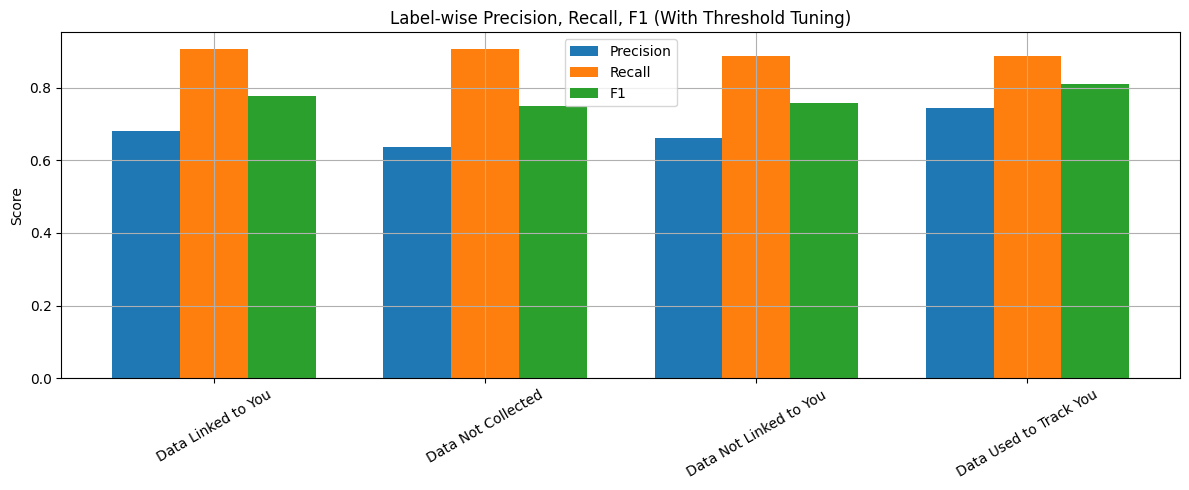

In [22]:
# %%
# Plot label-wise precision, recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(all_true, final_preds, zero_division=0)
labels = mlb_privacy.classes_

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1')

plt.xticks(x, labels, rotation=30)
plt.ylabel("Score")
plt.title("Label-wise Precision, Recall, F1 (With Threshold Tuning)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
